## Ottimizzazione di portafoglio
Lewinson (2020) Python for Finance Cookbook - cap. 7

In [1]:
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
import matplotlib.pyplot as plt
import warnings
#import seaborn as sns

#plt.style.use('seaborn')
#sns.set_palette('cubehelix')
# plt.style.use('seaborn-colorblind') #alternative
plt.rcParams['figure.figsize'] = [8, 4.5]
plt.rcParams['figure.dpi'] = 300
warnings.simplefilter(action='ignore', category=FutureWarning)

from datetime import date, datetime
import numpy as np
import pandas as pd
#import pandas_datareader.data as web
import yfinance as yf

### Frontiera efficiente con metodo Monte Carlo - 1

Parametri

In [39]:
n_port = 10 ** 5
n_days = 252
#risky_assets = ['AMZN', 'TSLA', 'AAPL', 'MSFT']
risky_assets = ['AMZN', 'KO', 'BA', 'JPM']
risky_assets.sort()
start_date = '2014-5-31'
end_date = '2024-5-24'
n_assets = len(risky_assets)
risky_assets

['AMZN', 'BA', 'JPM', 'KO']

Scarichiamo i prezzi

In [40]:
prices_df = yf.download(risky_assets, start_date, end_date) 
print(f'Downloaded {prices_df.shape[0]} rows of data.')

[*********************100%%**********************]  4 of 4 completed

Downloaded 2513 rows of data.


In [41]:

prices_df['Adj Close'].plot(title='Stock prices of the considered assets')
plt.grid();

Calcoliamo rendimenti e volatilità

In [42]:
returns_df = prices_df['Adj Close'].pct_change().dropna()
avg_returns = returns_df.mean() * n_days
cov_mat = returns_df.cov() * n_days


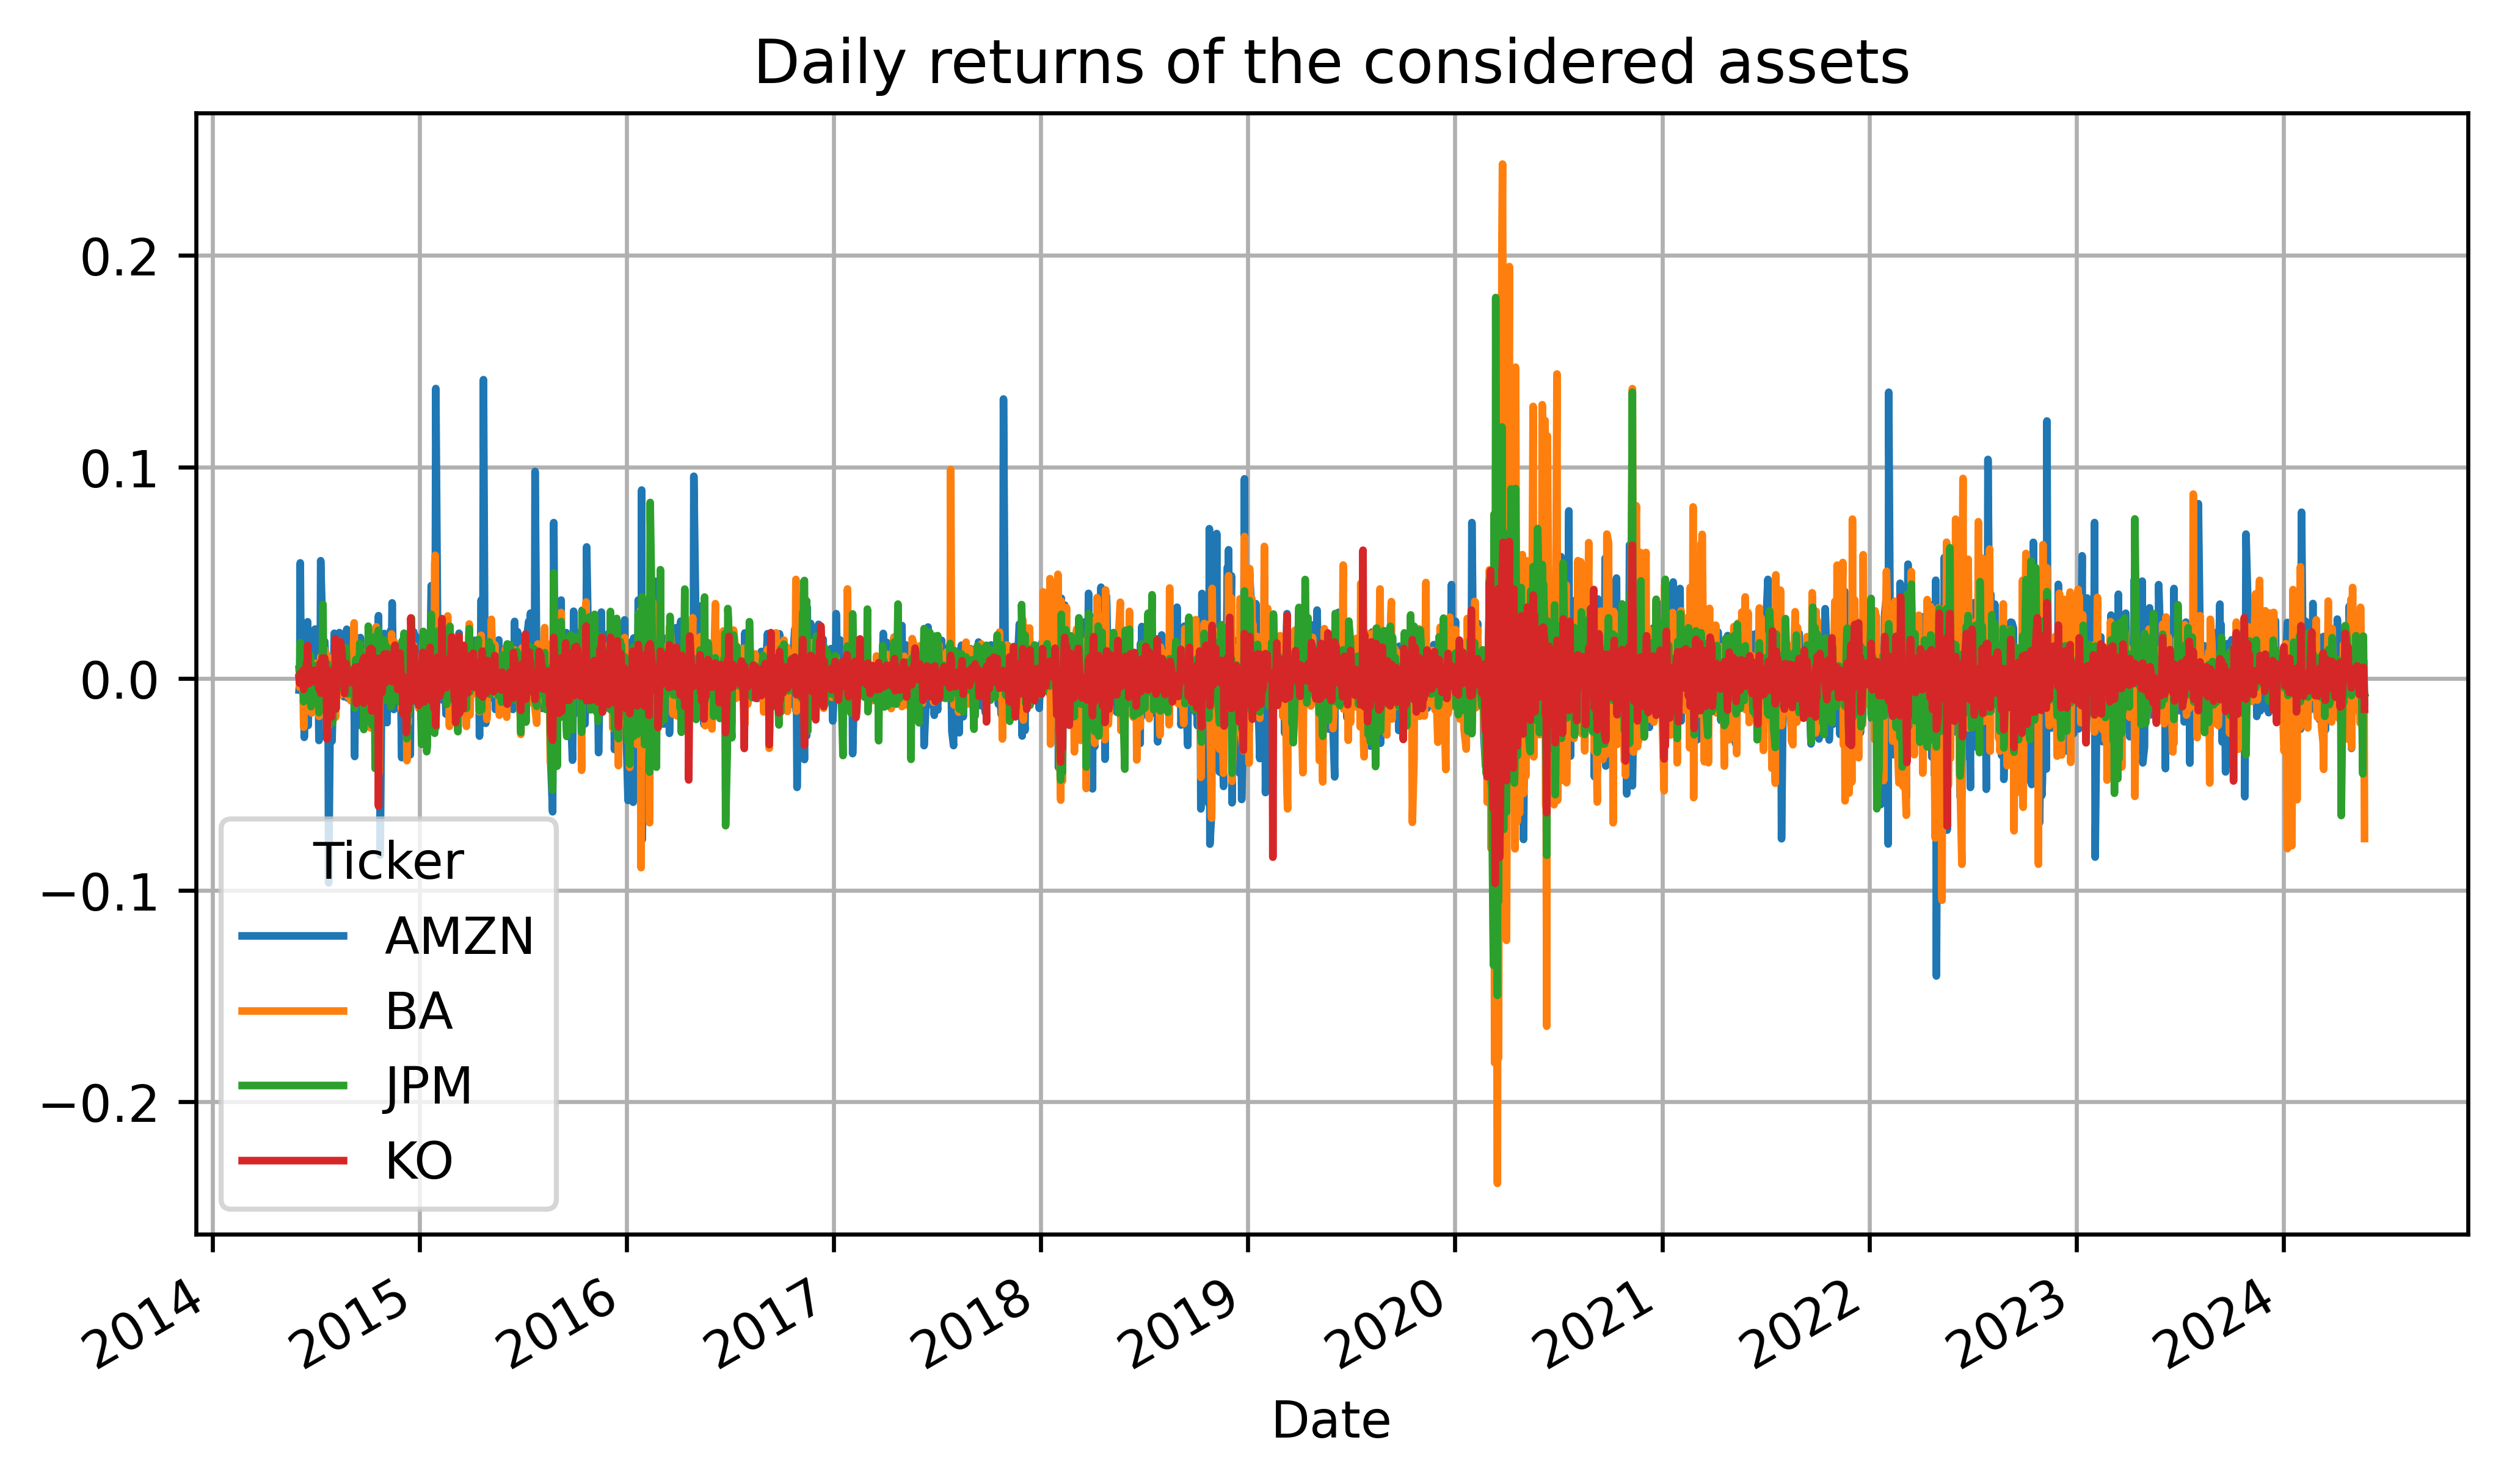

In [43]:
returns_df.plot(title='Daily returns of the considered assets')
plt.grid();

Simuliamo portafogli con pesi casuali

In [44]:


np.random.seed(42)
weights = np.random.random(size=(n_port, n_assets))
weights /=  np.sum(weights, axis=1)[:, np.newaxis]

In [45]:
weights

array([[0.14102156, 0.35796222, 0.27560979, 0.22540643],
       [0.12620081, 0.1261813 , 0.04698284, 0.70063506],
       [0.2613905 , 0.30790022, 0.00895102, 0.42175826],
       ...,
       [0.24844023, 0.35095292, 0.34779874, 0.05280811],
       [0.26525555, 0.15257129, 0.28992551, 0.29224765],
       [0.12145388, 0.25651504, 0.39812299, 0.22390809]])

Calcoliamo i rendimenti di portafoglio

In [46]:

portf_rtns = np.dot(weights, avg_returns)

portf_vol = []
for i in range(0, len(weights)):
    portf_vol.append(np.sqrt(np.dot(weights[i].T, 
                                    np.dot(cov_mat, weights[i]))))
portf_vol = np.array(portf_vol)  
portf_sharpe_ratio = portf_rtns / portf_vol

Creiamo un df con tutti i dati

In [47]:
portf_results_df = pd.DataFrame({'returns': portf_rtns,
                                 'volatility': portf_vol,
                                 'sharpe_ratio': portf_sharpe_ratio})

In [48]:
portf_results_df.head()

returns  volatility  sharpe_ratio
0  0.157488    0.235438      0.668914
1  0.124755    0.176684      0.706092
2  0.154368    0.212240      0.727327
3  0.231522    0.244219      0.948010
4  0.168794    0.234488      0.719842

Creazione della frontiera efficiente


In [49]:

n_points = 100
portf_vol_ef = []
indices_to_skip = []

portf_rtns_ef = np.linspace(portf_results_df.returns.min(), 
                            portf_results_df.returns.max(), 
                           n_points)
portf_rtns_ef = np.round(portf_rtns_ef, 2)    
portf_rtns = np.round(portf_rtns, 2)

for point_index in range(n_points):
    if portf_rtns_ef[point_index] not in portf_rtns:
        indices_to_skip.append(point_index)
        continue
    matched_ind = np.where(portf_rtns == portf_rtns_ef[point_index])
    portf_vol_ef.append(np.min(portf_vol[matched_ind]))
    
portf_rtns_ef = np.delete(portf_rtns_ef, indices_to_skip)
    

In [50]:
MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.plot(portf_vol_ef, portf_rtns_ef, 'b--')
for asset_index in range(n_assets):
    ax.scatter(x=np.sqrt(cov_mat.iloc[asset_index, asset_index]), 
                y=avg_returns[asset_index], 
                marker=MARKS[asset_index], 
                s=150, 
                color='black',
                label=risky_assets[asset_index])
ax.legend()

plt.tight_layout()
plt.grid()
plt.show()


#### Ricerca del portafoglio con l'indice di Sharpe più alto

In [51]:
max_sharpe_ind = np.argmax(portf_results_df.sharpe_ratio)
max_sharpe_portf = portf_results_df.loc[max_sharpe_ind]

min_vol_ind = np.argmin(portf_results_df.volatility)
min_vol_portf = portf_results_df.loc[min_vol_ind]

In [52]:
print('Maximum Sharpe Ratio portfolio')
print('Performance')
for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(risky_assets, weights[np.argmax(portf_results_df.sharpe_ratio)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)


Maximum Sharpe Ratio portfolio
Performance
returns: 23.14% volatility: 22.41% sharpe_ratio: 103.26% 
Weights
AMZN: 51.11% BA: 0.03% JPM: 33.33% KO: 15.53% 

In [53]:
print('Minimum Volatility portfolio ----')
print('Performance')
for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)
print('\nWeights')
for x, y in zip(risky_assets, weights[np.argmin(portf_results_df.volatility)]):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
returns: 13.14% volatility: 16.85% sharpe_ratio: 77.97% 
Weights
AMZN: 12.64% BA: 0.04% JPM: 14.56% KO: 72.76% 

In [54]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
ax.scatter(x=max_sharpe_portf.volatility, 
           y=max_sharpe_portf.returns, 
           c='black', marker='*', 
           s=200, label='Max Sharpe Ratio')
ax.scatter(x=min_vol_portf.volatility, 
           y=min_vol_portf.returns, 
           c='black', marker='P', 
           s=200, label='Minimum Volatility')
ax.set(xlabel='Volatility', ylabel='Expected Returns', 
       title='Efficient Frontier')
ax.legend()

plt.tight_layout()
plt.grid()
plt.show()

### Frontiera efficiente con la funzione di ottimizzazione di scipy

In [55]:
import numpy as np
import scipy.optimize as sco

In [56]:
def get_portf_rtn(w, avg_rtns):
    return np.sum(avg_rtns * w)

def get_portf_vol(w, avg_rtns, cov_mat):
    return np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))

In [57]:
def get_efficient_frontier(avg_rtns, cov_mat, rtns_range):
    
    efficient_portfolios = []
    
    n_assets = len(avg_returns)
    args = (avg_returns, cov_mat)
    bounds = tuple((0,1) for asset in range(n_assets))
    initial_guess = n_assets * [1. / n_assets, ]
    
    for ret in rtns_range:
        constraints = ({'type': 'eq', 
                        'fun': lambda x: get_portf_rtn(x, avg_rtns) - ret},
                       {'type': 'eq', 
                        'fun': lambda x: np.sum(x) - 1})
        efficient_portfolio = sco.minimize(get_portf_vol, initial_guess, 
                                           args=args, method='SLSQP', 
                                           constraints=constraints,
                                           bounds=bounds)
        efficient_portfolios.append(efficient_portfolio)
    
    return efficient_portfolios

In [58]:
rtns_range = np.linspace(-0.22, 0.32, 200)

In [59]:
efficient_portfolios = get_efficient_frontier(avg_returns, 
                                              cov_mat, 
                                              rtns_range)

In [60]:
vols_range = [x['fun'] for x in efficient_portfolios]

In [64]:
fig, ax = plt.subplots()
portf_results_df.plot(kind='scatter', x='volatility', 
                      y='returns', c='sharpe_ratio',
                      cmap='RdYlGn', edgecolors='black', 
                      ax=ax)
#ax.plot(vols_range, rtns_range, 'b--', linewidth=3)
ax.set(xlabel='Volatility', 
       ylabel='Expected Returns', 
       title='Efficient Frontier')

#plt.ylim(0.25,0.45)
plt.ylim(0,0.35)
plt.grid()
plt.show()

Portafoglio con minima volatilità

In [65]:
min_vol_ind = np.argmin(vols_range)
min_vol_portf_rtn = rtns_range[min_vol_ind]
min_vol_portf_vol = efficient_portfolios[min_vol_ind]['fun']

min_vol_portf = {'Return': min_vol_portf_rtn,
                 'Volatility': min_vol_portf_vol,
                 'Sharpe Ratio': (min_vol_portf_rtn / 
                                  min_vol_portf_vol)}

min_vol_portf

{'Return': 0.13005025125628142,
 'Volatility': 0.16815980649607176,
 'Sharpe Ratio': 0.7733729835097034}

Sommario dei risultati

In [66]:
print('Minimum Volatility portfolio ----')
print('Performance')

for index, value in min_vol_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(risky_assets, efficient_portfolios[min_vol_ind]['x']):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Minimum Volatility portfolio ----
Performance
Return: 13.01% Volatility: 16.82% Sharpe Ratio: 77.34% 
Weights
AMZN: 14.15% BA: 0.00% JPM: 10.15% KO: 75.70% 

Ricerca del portafoglio con il massimo Sharpe ratio

Funzione obiettivo

In [67]:
def neg_sharpe_ratio(w, avg_rtns, cov_mat, rf_rate):
    portf_returns = np.sum(avg_rtns * w)
    portf_volatility = np.sqrt(np.dot(w.T, np.dot(cov_mat, w)))
    portf_sharpe_ratio = (portf_returns - rf_rate) / portf_volatility
    return -portf_sharpe_ratio

Ricerca del portafoglio ottimale

In [68]:
n_assets = len(avg_returns)
RF_RATE = 0.04

args = (avg_returns, cov_mat, RF_RATE)
constraints = ({'type': 'eq', 
                'fun': lambda x: np.sum(x) - 1})
bounds = tuple((0,1) for asset in range(n_assets))
initial_guess = n_assets * [1. / n_assets]

max_sharpe_portf = sco.minimize(neg_sharpe_ratio, 
                                x0=initial_guess, 
                                args=args,
                                method='SLSQP', 
                                bounds=bounds, 
                                constraints=constraints)

In [69]:
max_sharpe_portf_w = max_sharpe_portf['x']
max_sharpe_portf = {'Return': get_portf_rtn(max_sharpe_portf_w, 
                                            avg_returns),
                    'Volatility': get_portf_vol(max_sharpe_portf_w, 
                                                avg_returns, 
                                                cov_mat),
                    'Sharpe Ratio': -max_sharpe_portf['fun']}
max_sharpe_portf

{'Return': 0.2582858397849644,
 'Volatility': 0.25211618946475806,
 'Sharpe Ratio': 0.865814449474207}

In [70]:
print('Maximum Sharpe Ratio portfolio ----')
print('Performance')

for index, value in max_sharpe_portf.items():
    print(f'{index}: {100 * value:.2f}% ', end="", flush=True)

print('\nWeights')
for x, y in zip(risky_assets, max_sharpe_portf_w):
    print(f'{x}: {100*y:.2f}% ', end="", flush=True)

Maximum Sharpe Ratio portfolio ----
Performance
Return: 25.83% Volatility: 25.21% Sharpe Ratio: 86.58% 
Weights
AMZN: 61.23% BA: 0.00% JPM: 38.77% KO: 0.00% 

### Ottimizzazione da un altro punto di vista: l'avversione al rischio

In [71]:
pip install cvxpy

Note: you may need to restart the kernel to use updated packages.


In [1]:
pip install qdldl

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install osqp

Note: you may need to restart the kernel to use updated packages.


In [2]:
pip install --upgrade --force-reinstall osqp

Note: you may need to restart the kernel to use updated packages.
     ---------------------------------------- 0.0/61.0 kB ? eta -:--:--
     --------------------------------- ------ 51.2/61.0 kB 1.3 MB/s eta 0:00:01
     ---------------------------------------- 61.0/61.0 kB 1.1 MB/s eta 0:00:00
     ---------------------------------------- 0.0/60.6 kB ? eta -:--:--
     ---------------------------------------- 60.6/60.6 kB 3.1 MB/s eta 0:00:00
   ---------------------------------------- 0.0/293.0 kB ? eta -:--:--
   --------------------------------------- 293.0/293.0 kB 18.8 MB/s eta 0:00:00
   ---------------------------------------- 0.0/15.8 MB ? eta -:--:--
   --- ------------------------------------ 1.2/15.8 MB 39.6 MB/s eta 0:00:01
   --- ------------------------------------ 1.5/15.8 MB 19.6 MB/s eta 0:00:01
   -------- ------------------------------- 3.4/15.8 MB 31.3 MB/s eta 0:00:01
   ---------- ----------------------------- 4.1/15.8 MB 26.0 MB/s eta 0:00:01
   ----------- --

  You can safely remove it manually.
  You can safely remove it manually.
  You can safely remove it manually.
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.0 requires FuzzyTM>=0.4.0, which is not installed.


In [72]:
import cvxpy as cp

In [73]:
avg_returns = avg_returns.values
cov_mat = cov_mat.values

In [74]:
weights = cp.Variable(n_assets)
gamma = cp.Parameter(nonneg=True)
portf_rtn_cvx = avg_returns @ weights 
portf_vol_cvx = cp.quad_form(weights, cov_mat)
objective_function = cp.Maximize(portf_rtn_cvx - gamma * portf_vol_cvx)
problem = cp.Problem(objective_function, 
                     [cp.sum(weights) == 1, weights >= 0])

In [75]:
N_POINTS = 25
portf_rtn_cvx_ef = np.zeros(N_POINTS)
portf_vol_cvx_ef = np.zeros(N_POINTS)
weights_ef = []
gamma_range = np.logspace(-3, 3, num=N_POINTS)

for i in range(N_POINTS):
    gamma.value = gamma_range[i]
    problem.solve()
    portf_vol_cvx_ef[i] = cp.sqrt(portf_vol_cvx).value
    portf_rtn_cvx_ef[i] = portf_rtn_cvx.value
    weights_ef.append(weights.value)

In [76]:
weights_df = pd.DataFrame(weights_ef, 
                          columns=risky_assets, 
                          index=np.round(gamma_range, 3))
ax = weights_df.plot(kind='bar', stacked=True) 
ax.set(title='Weights allocation per risk-aversion level',
       xlabel=r'$\gamma$', 
       ylabel='weight')
ax.legend(bbox_to_anchor=(1,1))

plt.tight_layout()

plt.show()

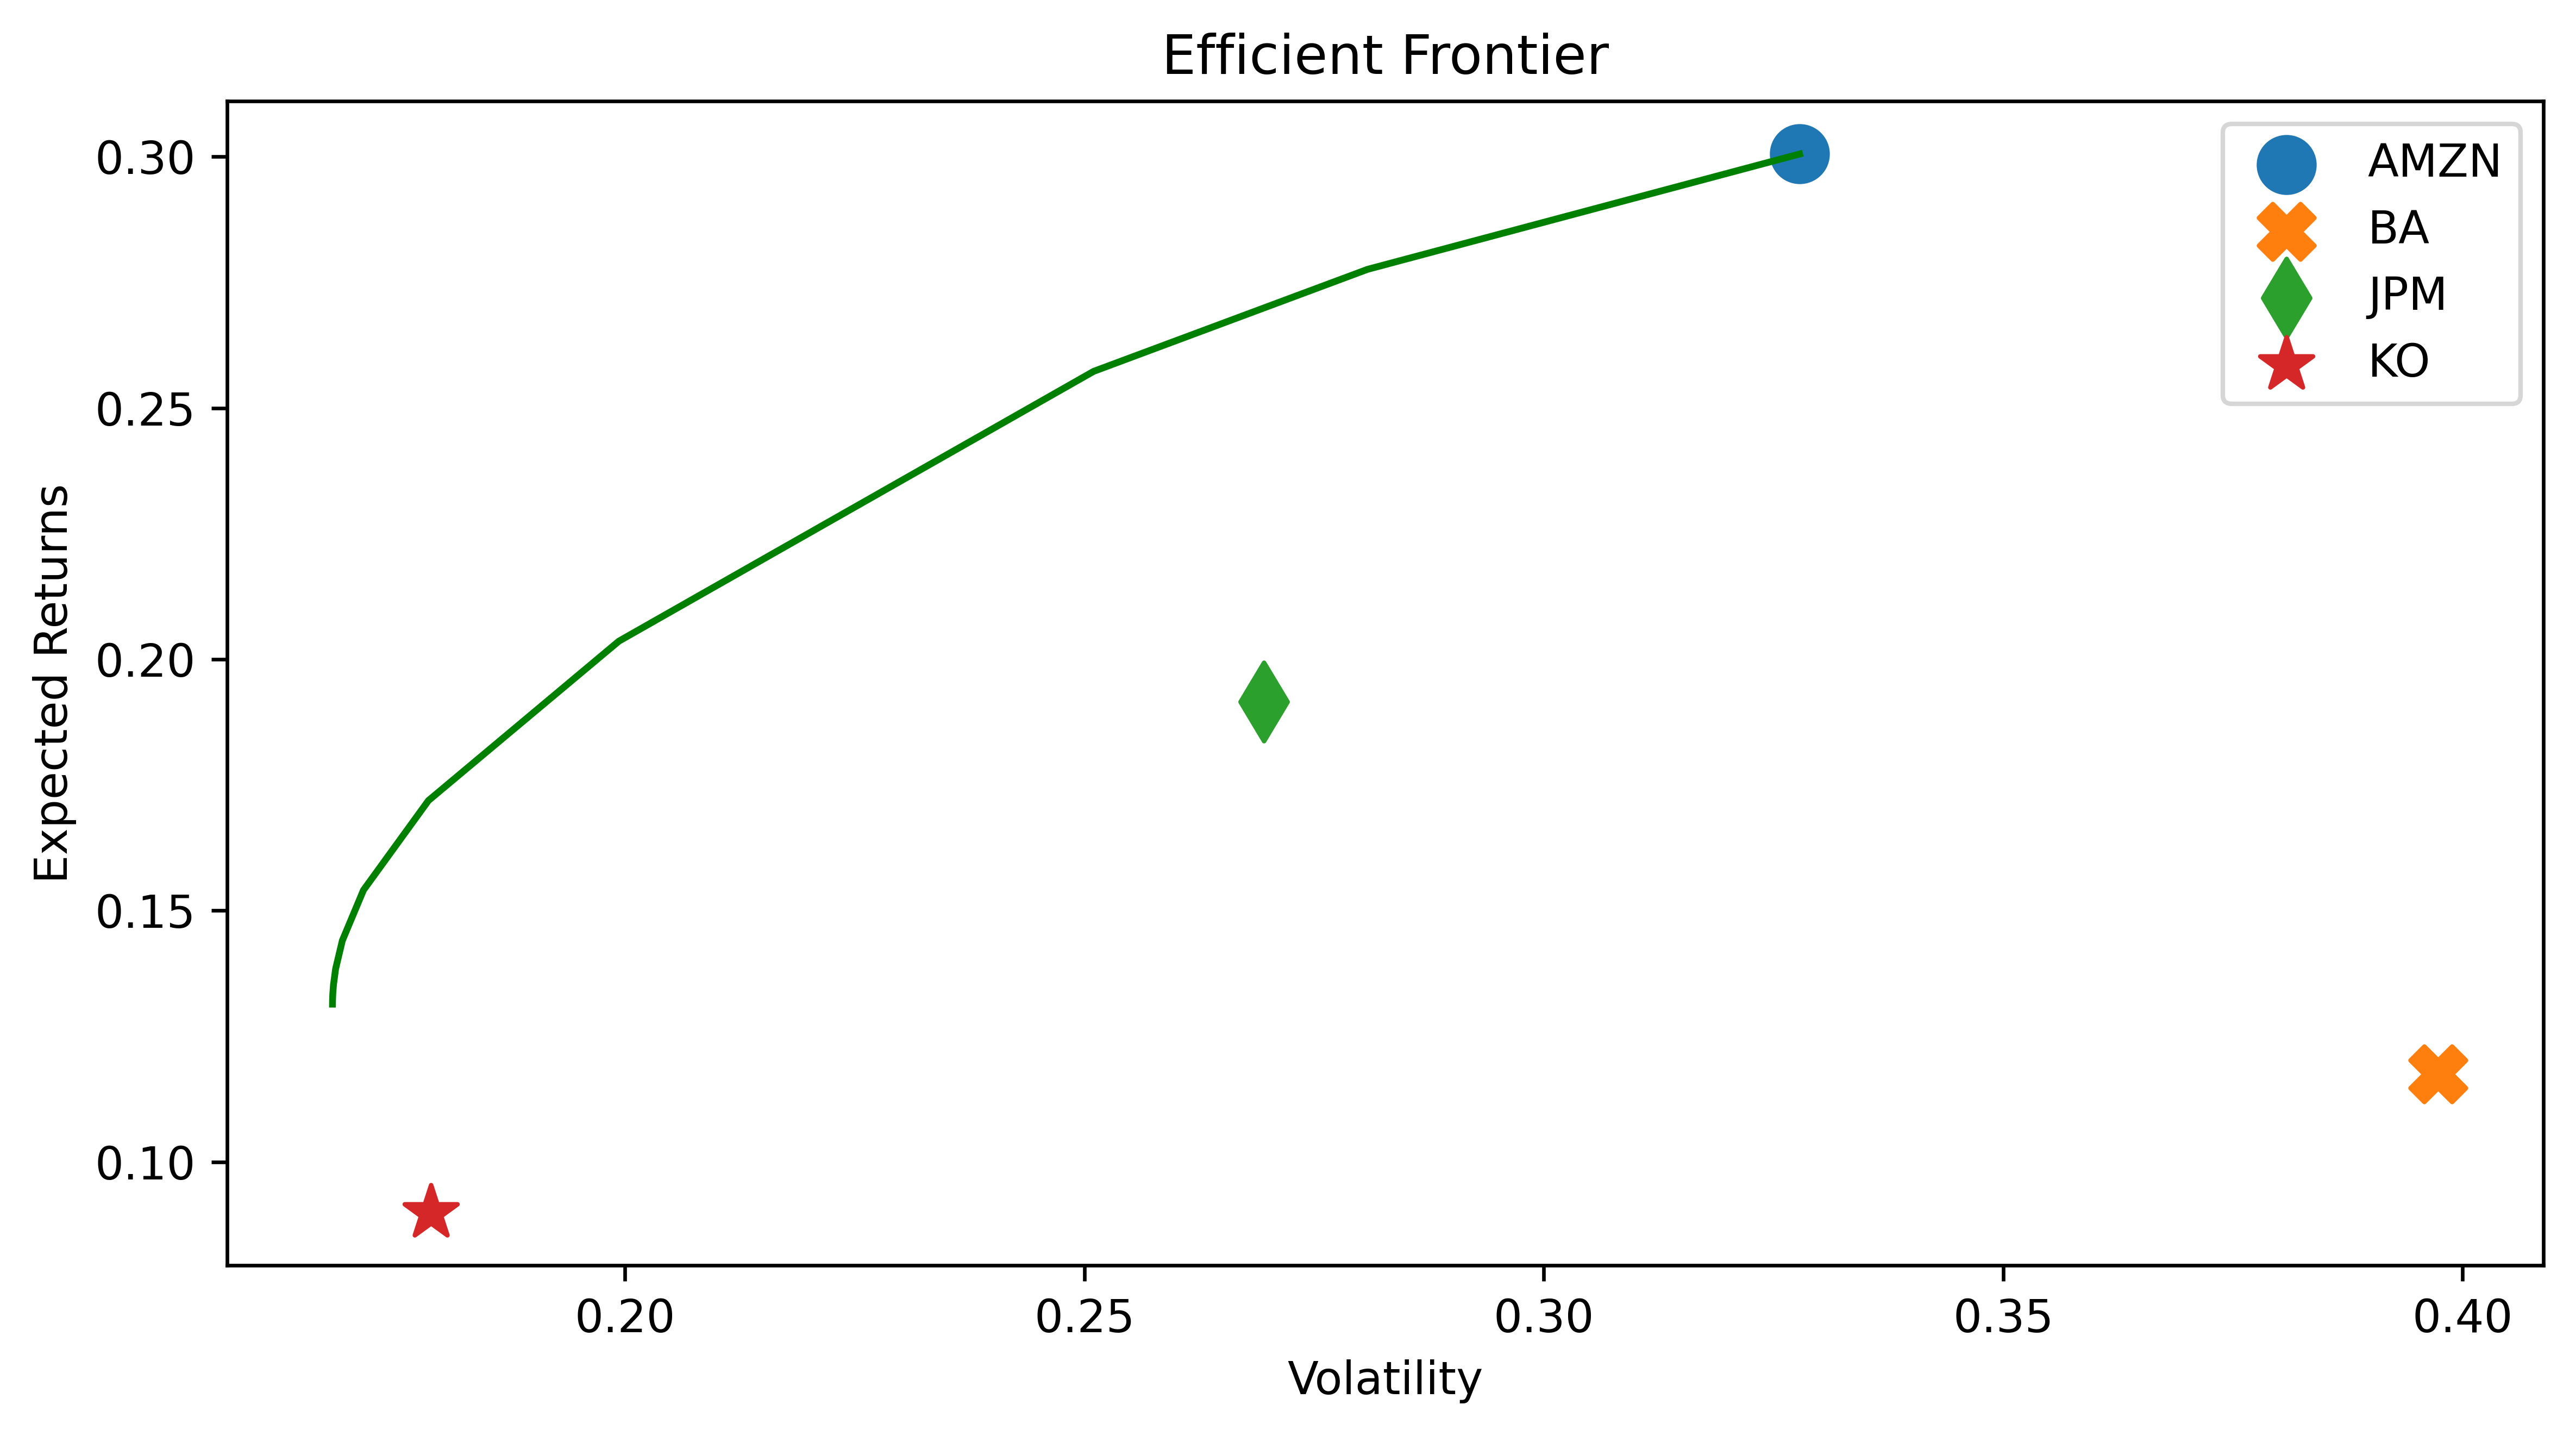

In [77]:
#MARKS = ['o', 'X', 'd', '*']

fig, ax = plt.subplots()
ax.plot(portf_vol_cvx_ef, portf_rtn_cvx_ef, 'g-')
for asset_index in range(n_assets):
     plt.scatter(x=np.sqrt(cov_mat[asset_index, asset_index]), 
                 y=avg_returns[asset_index], 
                 marker=MARKS[asset_index], 
                 label=risky_assets[asset_index],
                 s=150)
ax.set(title='Efficient Frontier',
       xlabel='Volatility', 
       ylabel='Expected Returns', )
ax.legend()

plt.tight_layout()

plt.show()